In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

## Load Image and Plot Slice/Annotation

In [3]:
def load_image(annotation_path, slice_path, plots = True):
    # Reading in images and converting to RGB for plotting
    annotation = cv.cvtColor(cv.imread(annotation_path), cv.COLOR_BGR2RGB)
    slice = cv.cvtColor(cv.imread(slice_path), cv.COLOR_BGR2RGB)

    # Creating plots
    if plots is True:
        fig, axes = plt.subplots(1, 2, figsize = (8, 8))
        plt.subplots_adjust(wspace = 0.3)
        axes[0].imshow(annotation)
        axes[0].set_title(os.path.basename(annotation_path))
        axes[1].imshow(slice)
        axes[1].set_title(os.path.basename(slice_path))
        plt.show()

    # Returning array sizes to verify that they are the same
    print(f"Annotation Shape: {annotation.shape} \nSlice Shape: {slice.shape}")

    # Return annotation and slice arrays
    return annotation, slice

## Get Masks and Plot Each

In [109]:
def get_external_contours(annotation, slice, plots = True):
    # Convert annotated image to grayscale
    annotation_gray = cv.cvtColor(annotation, cv.COLOR_RGB2GRAY)
    # All pixels with a grayscale value above 127 converted to white, all below converted to black
    thresh = cv.threshold(annotation_gray, 127, 255, 0)[1]
    # Get contours
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # Create list to store masks
    masks = []
    # Finding the parent and child contours (excluding the contour that just does the rectangular borders of the image)
    parents = np.unique(hierarchy[0, :, 3])
    parents = parents[parents >= 0]
    children = np.argwhere(np.isin(hierarchy[0, :, 3], parents)).ravel()
    # Get object masks
    while children.size != 0:
        # Take first child (every contour is a child of something because findContours includes the border as the top of the hierarchy)
        current = children[0]
        # Remove from list of children
        children = np.delete(children, 0)
        # Draw contour
        mask = np.zeros_like(annotation_gray)
        cv.drawContours(mask, contours, current, 255, 10)
        # If the current contour has any children, draw them on this mask as well
        # Imagine a donut, the first contour drawn will be the outer circle, this code then ensures that the inner circle is drawn too
        for j in np.argwhere(hierarchy[0, :, 3] == current).ravel():
            children = np.delete(children, np.argwhere(children == j))
            cv.drawContours(mask, contours, j, 255, 15)
        masks.append(mask)
    
    # Plot object masks and annotation
    if plots is True:
        number = len(masks)
        fig, axes = plt.subplots(1, number + 1, figsize = (4 * (number + 1), 4 * (number + 1)))
        plt.subplots_adjust(wspace = 0.3)
        for i in range(number):
            mask = masks[i]
            axes[i].imshow(mask, 'gray', vmin = 0, vmax = 255)
            axes[i].set_title(f'Mask {i + 1}')
        axes[number].imshow(annotation)
        axes[number].set_title("Annotated Epithelium")
        plt.show()

    # Because of the way Ryan's algorithm works, now need to return the external contours of the masks that were just created
    external_contours = []
    for mask in masks:
        contour, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        external_contour = np.zeros_like(annotation_gray)
        external_contour = cv.drawContours(external_contour, contour, -1, 255, 10)
        external_contours.append(external_contour)
    
    # Plotting external contours and original slice
    if plots is True:
        number = len(external_contours)
        fig, axes = plt.subplots(1, number + 1, figsize = (4 * (number + 1), 4 * (number + 1)))
        plt.subplots_adjust(wspace = 0.3)
        for i in range(number):
            external_contour = external_contours[i]
            axes[i].imshow(external_contour, 'gray', vmin = 0, vmax = 255)
            axes[i].set_title(f'External Contour {i + 1}')
        axes[number].imshow(slice)
        axes[number].set_title("Original")
        plt.show()
    
    # Return list of external_contours
    return external_contours

## Examples

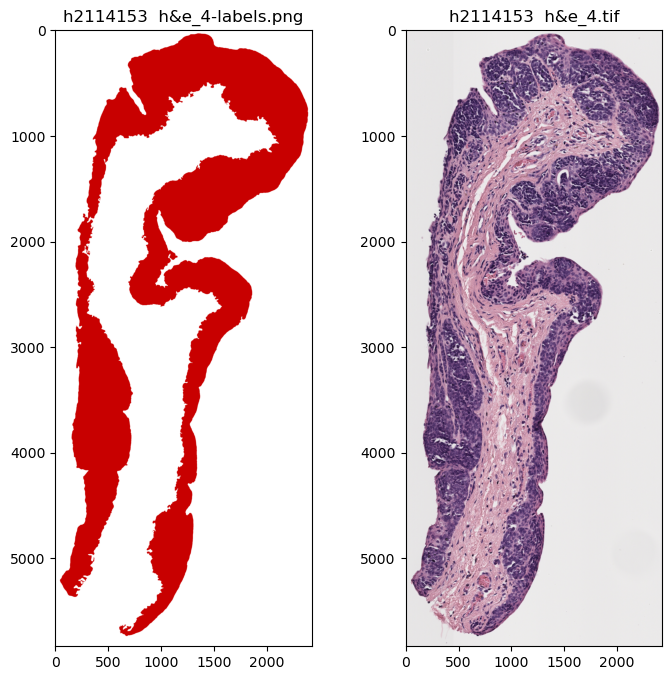

Annotation Shape: (5832, 2428, 3) 
Slice Shape: (5832, 2428, 3)


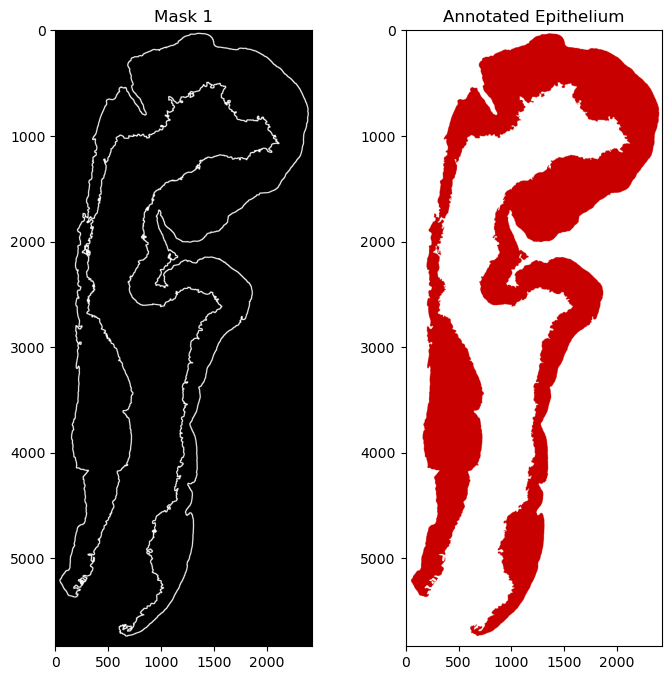

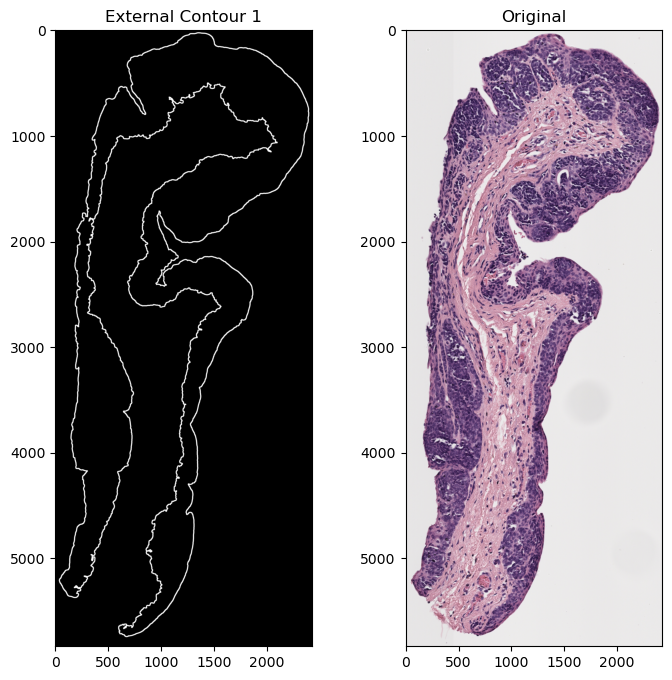

In [110]:
annotation_path = "./images/epithelium_extraction/export/h2114153  h&e_4-labels.png"
slice_path = "./images/tif_stains/h2114153  h&e_4.tif"

annotation, slice = load_image(annotation_path, slice_path)
external_contours = get_external_contours(annotation, slice)

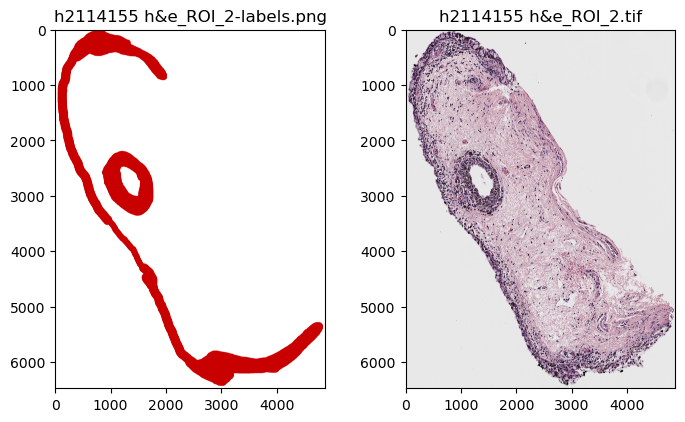

Annotation Shape: (6476, 4868, 3) 
Slice Shape: (6476, 4868, 3)


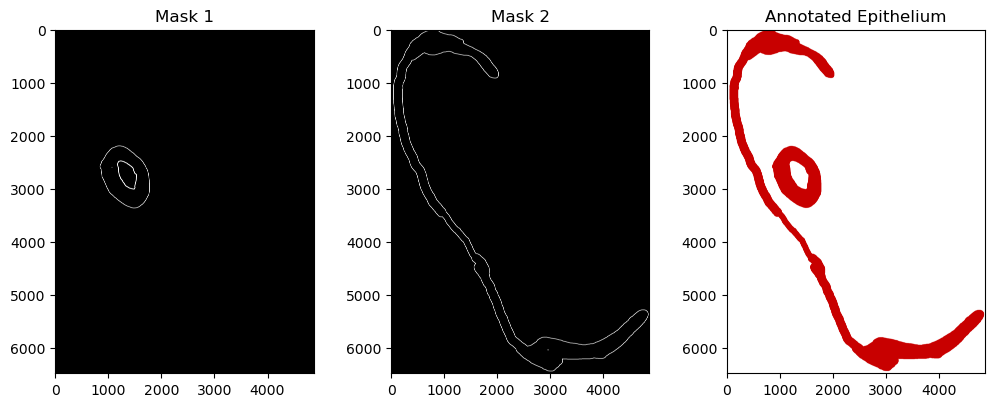

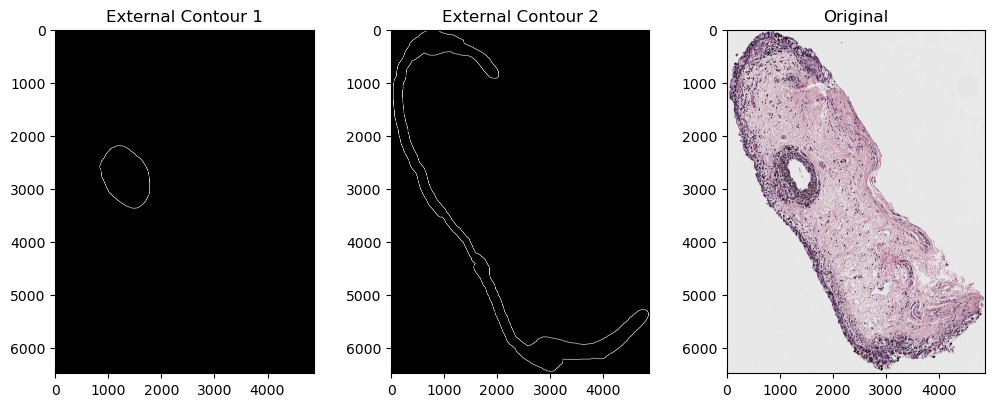

In [111]:
annotation_path = "./images/epithelium_extraction/export/h2114155 h&e_ROI_2-labels.png"
slice_path = "./images/tif_stains/h2114155 h&e_ROI_2.tif"

annotation, slice = load_image(annotation_path, slice_path)
external_contours = get_external_contours(annotation, slice)

- This is a modified version of the above example, where I just pretended the epithelium connected on the right side, illustrating how `findContours` handles "closed" epithelium shapes differently from "open" shapes
- That is the biggest stumbling block when it came to getting these contours to be separate
- In the above example, both objects are technically children of that overarching border contour
- In the below example, the donut is a child of the larger epithelium object, so it has to be dealt with differently

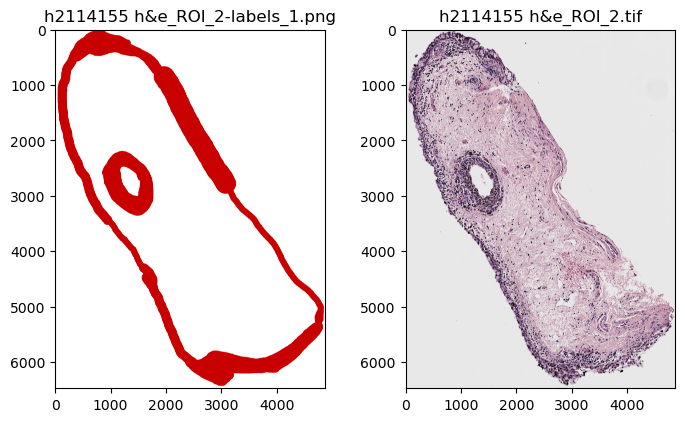

Annotation Shape: (6476, 4868, 3) 
Slice Shape: (6476, 4868, 3)


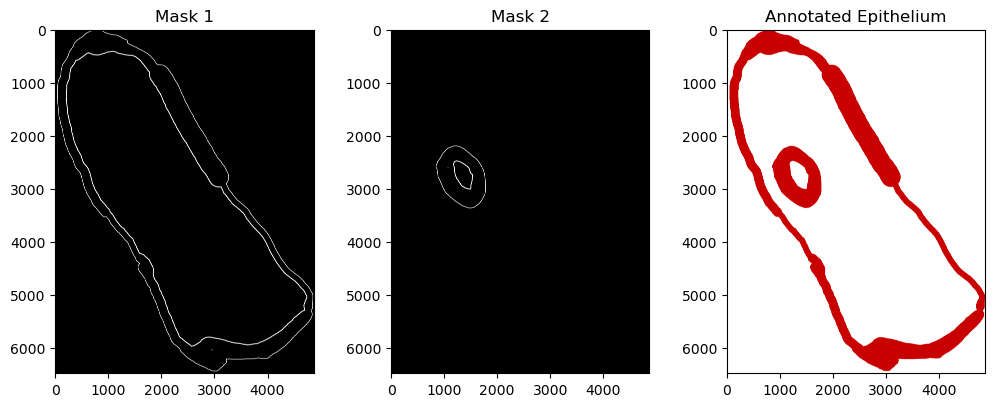

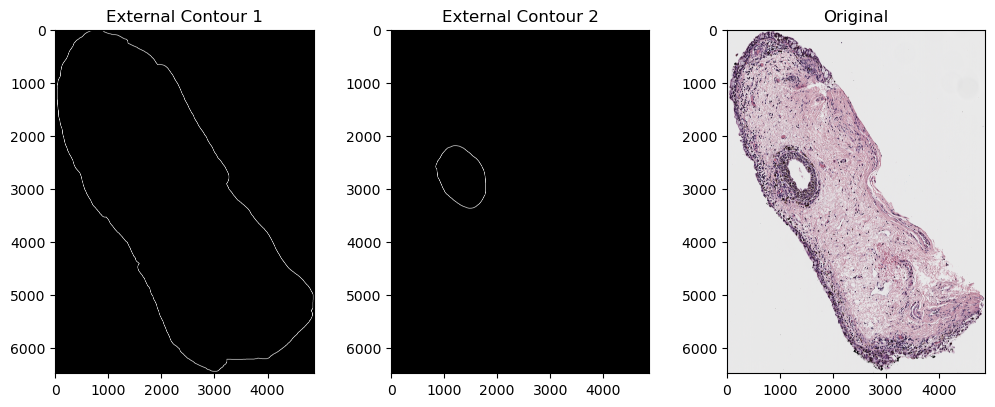

In [112]:
annotation_path = "./images/epithelium_extraction/export/h2114155 h&e_ROI_2-labels_1.png"
slice_path = "./images/tif_stains/h2114155 h&e_ROI_2.tif"

annotation, slice = load_image(annotation_path, slice_path)
external_contours = get_external_contours(annotation, slice)